In [2]:
import dill
dill.load_session('StudentCompleted_G.db')

/home/mke37/.local/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
2024-08-25 12:06:45.704476: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-25 12:06:45.704528: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-25 12:06:45.705690: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-25 12:06:45.715184: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructi

In [1]:
print("DEBUG")

DEBUG


In [1]:
from preprocess import NERDataset
from cleaning import DataReader
import numpy as np
from utils import compute_metrics, get_label_map, get_inv_label_map, read_labels
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, BertForTokenClassification, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import DataLoader
import torch
from torch import nn
from config import Config

from transformers import AutoTokenizer, BertForTokenClassification # Import AutoTokenizer and BertForTokenClassification from the transformers library for NLP tasks.
import torch # Import the PyTorch library for tensor computations and deep learning.
import numpy as np # Import NumPy for numerical operations and array manipulations.
import argparse # Import argparse for parsing command-line arguments.
from typing import List # Import List from the typing module for type annotations.
from config import Config # Import Config class from the config module, used for loading and accessing configuration settings.
# Import utility functions: read_labels (to read label data), get_label_map and get_inv_label_map (for mapping labels to indices and vice versa).
from utils import read_labels, get_label_map, get_inv_label_map
import argparse # Re-import argparse (duplicate import, not necessary).
import sys # Import sys for interacting with the Python interpreter (e.g., command-line arguments, system exit).

import os
import numpy as np
from fuzzywuzzy import fuzz
import re

import torch.nn.functional as F
from typing import Tuple

/home/mke37/.local/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
2024-06-13 03:50:18.307372: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-13 03:50:18.310415: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-13 03:50:18.312167: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-13 03:50:18.339358: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructi

In [2]:
sentences = []
labels = []

curr_sentence = []
curr_labels = []

with open("Labeled_SemiLabeledData_G.txt", "r") as file:
    for line in file:
        if line != "\n":
            label = line.split()[0]
            word = line.split()[1]
            
            curr_sentence.append(word)
            curr_labels.append(label)
        else:
            sentences.append(curr_sentence)
            labels.append(curr_labels)
            curr_sentence = []
            curr_labels = []
            
print("DONE!")           

DONE!


In [3]:
print(len(sentences), len(labels))
print(sentences[-1])
print(labels[-1])

21726 21726
['يعد', 'مرض', 'آلزهايمر', 'واحدا', 'من', 'أكثر', 'الأمراض', 'كلفة', 'مالية', 'في', 'الدول', 'المتقدمة', '.']
['OUTSIDE', 'OUTSIDE', 'B-Disease', 'OUTSIDE', 'OUTSIDE', 'OUTSIDE', 'OUTSIDE', 'OUTSIDE', 'OUTSIDE', 'OUTSIDE', 'OUTSIDE', 'OUTSIDE', 'OUTSIDE']


In [4]:
def remove_diacritics(text):
    return re.sub(re.compile(r'[\u0617-\u061A\u064B-\u0652]'),"", text)

In [5]:
for i in range(len(sentences)):
    for j in range(len(sentences[i])):
        sentences[i][j] = remove_diacritics(sentences[i][j])

In [6]:
class NERTrainer:
    def __init__(self, test_dataset_path):
        self.cfg = Config()
        self.data_reader = DataReader("Labeled_SemiLabeledData_G.txt")
        self.data, _, _ = self.data_reader.read_data_bert()
        self.label_list = read_labels('NewEntities.txt')

        self.label_map = get_label_map(self.label_list)
        self.inv_label_map = get_inv_label_map(self.label_list)

        # Load the test dataset
        self.test_data_reader = DataReader(test_dataset_path)
        self.test_data, _, _ = self.test_data_reader.read_data_bert()

        self.TOKENIZER = AutoTokenizer.from_pretrained(self.cfg.MODEL_NAME)

        self.train_dataset = NERDataset(
            texts=[x[0] for x in self.data],
            tags=[x[1] for x in self.data],
            label_list=self.label_list,
            model_name=self.cfg.MODEL_NAME,
            max_length=self.cfg.MAX_LEN
        )

        self.test_dataset = NERDataset(
            texts=[x[0] for x in self.test_data],
            tags=[x[1] for x in self.test_data],
            label_list=self.label_list,
            model_name=self.cfg.MODEL_NAME,
            max_length=self.cfg.MAX_LEN
        )

        self.train_data_loader = DataLoader(dataset=self.train_dataset, batch_size=self.cfg.TRAIN_BATCH_SIZE, shuffle=True)
        self.test_data_loader = DataLoader(dataset=self.test_dataset, batch_size=self.cfg.VALID_BATCH_SIZE, shuffle=False)

        self.model = BertForTokenClassification.from_pretrained(self.cfg.MODEL_NAME,
                                                                return_dict=True,
                                                                num_labels=len(self.label_map),
                                                                output_attentions=False,
                                                                output_hidden_states=False).to(self.cfg.device)

        self.optimizer = AdamW(self.model.parameters(), lr=5e-5, correct_bias=False)
        total_steps = len(self.train_data_loader) * self.cfg.EPOCHS

        self.scheduler = get_linear_schedule_with_warmup(
            self.optimizer,
            num_warmup_steps=0,
            num_training_steps=total_steps
        )

        self.best_eval_loss = float('inf')
        self.best_model = None

    def train_epoch(self):
        self.model.train()
        final_loss = 0

        for data in tqdm(self.train_data_loader, total=len(self.train_data_loader)):
            input_ids = data['input_ids'].to(self.cfg.device)
            attention_mask = data['attention_mask'].to(self.cfg.device)
            token_type_ids = data['token_type_ids'].to(self.cfg.device)
            labels = data['labels'].to(self.cfg.device)

            self.optimizer.zero_grad()
            outputs = self.model(input_ids=input_ids,
                                 token_type_ids=token_type_ids,
                                 attention_mask=attention_mask,
                                 labels=labels)

            loss = outputs.loss
            loss.backward()
            nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
            self.optimizer.step()
            self.scheduler.step()
            final_loss += loss.item()

        loss = final_loss / len(self.train_data_loader)
        print(f"Train loss: {loss}")

        return loss

    def eval_epoch(self):
        self.model.eval()
        final_loss = 0
        all_labels = []
        all_preds = []

        with torch.no_grad():
            for data in tqdm(self.test_data_loader, total=len(self.test_data_loader)):
                input_ids = data['input_ids'].to(self.cfg.device)
                attention_mask = data['attention_mask'].to(self.cfg.device)
                token_type_ids = data['token_type_ids'].to(self.cfg.device)
                labels = data['labels'].to(self.cfg.device)

                outputs = self.model(input_ids=input_ids,
                                     token_type_ids=token_type_ids,
                                     attention_mask=attention_mask,
                                     labels=labels)

                loss = outputs.loss
                final_loss += loss.item()

                logits = outputs.logits.detach().cpu().numpy()
                labels = labels.to('cpu').numpy()

                all_preds.extend(logits)
                all_labels.extend(labels)

        all_preds = np.array(all_preds)
        all_labels = np.asarray(all_labels)

        metrics = compute_metrics(all_preds, all_labels, self.inv_label_map, False)
        final_loss = final_loss / len(self.test_data_loader)

        print(f"Eval loss: {final_loss}")
        print(f"Eval Metrics: {metrics}")

        return final_loss, metrics

    def train(self):
        for epoch in range(self.cfg.EPOCHS):
            print(f"Training Epoch: {epoch + 1}")
            self.train_epoch()

            print(f"Evaluating Epoch: {epoch + 1}")
            eval_loss, _ = self.eval_epoch()

            if eval_loss < self.best_eval_loss:
                self.best_eval_loss = eval_loss
                self.best_model = self.model.state_dict()
                torch.save(self.best_model, "StudentG_Model.pt")


if __name__ == '__main__':
    test_dataset_path = "TestingData.txt"
    ner_trainer = NERTrainer(test_dataset_path)
    ner_trainer.train()
    print("DONE!")

Data: 21726 , Sentences: 21726 , Tags: 21726
Data: 856 , Sentences: 856 , Tags: 856


Some weights of BertForTokenClassification were not initialized from the model checkpoint at aubmindlab/bert-base-arabertv02 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training Epoch: 1


/apps/sw/miniconda/envs/transformers-r1/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/1358 [00:00<?, ?it/s]

Train loss: 0.23477632877456686
Evaluating Epoch: 1


  0%|          | 0/54 [00:00<?, ?it/s]

/home/mke37/.local/lib/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: OUTSIDE seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))


Eval loss: 0.5748514632383982
Eval Metrics: {'accuracy_score': 0.8881679201691, 'precision': 0.5973154362416108, 'recall': 0.5021701388888888, 'f1': 0.5456260315963216}
Training Epoch: 2


  0%|          | 0/1358 [00:00<?, ?it/s]

Train loss: 0.11477315382941439
Evaluating Epoch: 2


  0%|          | 0/54 [00:00<?, ?it/s]

Eval loss: 0.5408632370332876
Eval Metrics: {'accuracy_score': 0.8917563781153223, 'precision': 0.6184074457083765, 'recall': 0.5190972222222222, 'f1': 0.5644171779141104}
Training Epoch: 3


  0%|          | 0/1358 [00:00<?, ?it/s]

Train loss: 0.08661249982102587
Evaluating Epoch: 3


  0%|          | 0/54 [00:00<?, ?it/s]

Eval loss: 0.6762121099012869
Eval Metrics: {'accuracy_score': 0.8894460010814531, 'precision': 0.6186666666666667, 'recall': 0.5034722222222222, 'f1': 0.5551567360612587}
Training Epoch: 4


  0%|          | 0/1358 [00:00<?, ?it/s]

Train loss: 0.07004266916685059
Evaluating Epoch: 4


  0%|          | 0/54 [00:00<?, ?it/s]

Eval loss: 0.74682352402144
Eval Metrics: {'accuracy_score': 0.8916580641989874, 'precision': 0.6292073832790445, 'recall': 0.5030381944444444, 'f1': 0.5590931017848529}
Training Epoch: 5


  0%|          | 0/1358 [00:00<?, ?it/s]

Train loss: 0.05957132014507683
Evaluating Epoch: 5


  0%|          | 0/54 [00:00<?, ?it/s]

Eval loss: 0.7287734589642949
Eval Metrics: {'accuracy_score': 0.8891510593324485, 'precision': 0.6075819672131147, 'recall': 0.5147569444444444, 'f1': 0.5573308270676691}
Training Epoch: 6


  0%|          | 0/1358 [00:00<?, ?it/s]

Train loss: 0.05193037115790455
Evaluating Epoch: 6


  0%|          | 0/54 [00:00<?, ?it/s]

Eval loss: 0.8035496779614024
Eval Metrics: {'accuracy_score': 0.8912156515754805, 'precision': 0.6133886870783601, 'recall': 0.5130208333333334, 'f1': 0.558733160009454}
Training Epoch: 7


  0%|          | 0/1358 [00:00<?, ?it/s]

Train loss: 0.045537479612043616
Evaluating Epoch: 7


  0%|          | 0/54 [00:00<?, ?it/s]

Eval loss: 0.8299842783146434
Eval Metrics: {'accuracy_score': 0.8915597502826526, 'precision': 0.6197183098591549, 'recall': 0.515625, 'f1': 0.5628997867803838}
Training Epoch: 8


  0%|          | 0/1358 [00:00<?, ?it/s]

Train loss: 0.041594349449145196
Evaluating Epoch: 8


  0%|          | 0/54 [00:00<?, ?it/s]

Eval loss: 0.8267502185923082
Eval Metrics: {'accuracy_score': 0.8906749250356388, 'precision': 0.6061855670103092, 'recall': 0.5104166666666666, 'f1': 0.5541941564561734}
Training Epoch: 9


  0%|          | 0/1358 [00:00<?, ?it/s]

Train loss: 0.037042257337953036
Evaluating Epoch: 9


  0%|          | 0/54 [00:00<?, ?it/s]

Eval loss: 0.9674960369313205
Eval Metrics: {'accuracy_score': 0.8917072211571548, 'precision': 0.6260593220338984, 'recall': 0.5130208333333334, 'f1': 0.5639312977099237}
Training Epoch: 10


  0%|          | 0/1358 [00:00<?, ?it/s]

Train loss: 0.03425361372946058
Evaluating Epoch: 10


  0%|          | 0/54 [00:00<?, ?it/s]

Eval loss: 0.9104320324129529
Eval Metrics: {'accuracy_score': 0.8924445755296663, 'precision': 0.6228660113812726, 'recall': 0.5225694444444444, 'f1': 0.5683266462119423}
Training Epoch: 11


  0%|          | 0/1358 [00:00<?, ?it/s]

Train loss: 0.03139747833968202
Evaluating Epoch: 11


  0%|          | 0/54 [00:00<?, ?it/s]

Eval loss: 1.0501538095650849
Eval Metrics: {'accuracy_score': 0.8911664946173131, 'precision': 0.6198521647307286, 'recall': 0.5095486111111112, 'f1': 0.5593139590281087}
Training Epoch: 12


  0%|          | 0/1358 [00:00<?, ?it/s]

Train loss: 0.02929932904111349
Evaluating Epoch: 12


  0%|          | 0/54 [00:00<?, ?it/s]

Eval loss: 1.0273340021570523
Eval Metrics: {'accuracy_score': 0.8931327729440103, 'precision': 0.6224436287362349, 'recall': 0.5151909722222222, 'f1': 0.5637615768226074}
Training Epoch: 13


  0%|          | 0/1358 [00:00<?, ?it/s]

Train loss: 0.02770171039866778
Evaluating Epoch: 13


  0%|          | 0/54 [00:00<?, ?it/s]

Eval loss: 1.0695080312865752
Eval Metrics: {'accuracy_score': 0.8913631224499828, 'precision': 0.6145778710015731, 'recall': 0.5086805555555556, 'f1': 0.5566373782949419}
Training Epoch: 14


  0%|          | 0/1358 [00:00<?, ?it/s]

Train loss: 0.02599223124168351
Evaluating Epoch: 14


  0%|          | 0/54 [00:00<?, ?it/s]

Eval loss: 1.10303486055798
Eval Metrics: {'accuracy_score': 0.8922479476969966, 'precision': 0.62148070907195, 'recall': 0.5173611111111112, 'f1': 0.5646612979630506}
Training Epoch: 15


  0%|          | 0/1358 [00:00<?, ?it/s]

Train loss: 0.024220795116558502
Evaluating Epoch: 15


  0%|          | 0/54 [00:00<?, ?it/s]

Eval loss: 1.1157305930499677
Eval Metrics: {'accuracy_score': 0.89160890724082, 'precision': 0.615866388308977, 'recall': 0.5121527777777778, 'f1': 0.5592417061611376}
Training Epoch: 16


  0%|          | 0/1358 [00:00<?, ?it/s]

Train loss: 0.023362517274147385
Evaluating Epoch: 16


  0%|          | 0/54 [00:00<?, ?it/s]

Eval loss: 1.152050651885845
Eval Metrics: {'accuracy_score': 0.8910681807009783, 'precision': 0.6178010471204188, 'recall': 0.5121527777777778, 'f1': 0.5600379686758424}
Training Epoch: 17


  0%|          | 0/1358 [00:00<?, ?it/s]

Train loss: 0.022115027044642327
Evaluating Epoch: 17


  0%|          | 0/54 [00:00<?, ?it/s]

Eval loss: 1.1705885270127543
Eval Metrics: {'accuracy_score': 0.8916580641989874, 'precision': 0.6184696569920844, 'recall': 0.5086805555555556, 'f1': 0.5582281495594189}
Training Epoch: 18


  0%|          | 0/1358 [00:00<?, ?it/s]

Train loss: 0.020812526579926733
Evaluating Epoch: 18


  0%|          | 0/54 [00:00<?, ?it/s]

Eval loss: 1.2000986094828006
Eval Metrics: {'accuracy_score': 0.8911173376591457, 'precision': 0.6186708860759493, 'recall': 0.5091145833333334, 'f1': 0.5585714285714286}
Training Epoch: 19


  0%|          | 0/1358 [00:00<?, ?it/s]

Train loss: 0.020056406569039478
Evaluating Epoch: 19


  0%|          | 0/54 [00:00<?, ?it/s]

Eval loss: 1.2160659884964977
Eval Metrics: {'accuracy_score': 0.8917563781153223, 'precision': 0.6198217094913476, 'recall': 0.5130208333333334, 'f1': 0.5613868439800523}
Training Epoch: 20


  0%|          | 0/1358 [00:00<?, ?it/s]

Train loss: 0.019125314057031915
Evaluating Epoch: 20


  0%|          | 0/54 [00:00<?, ?it/s]

Eval loss: 1.242548222343127
Eval Metrics: {'accuracy_score': 0.8917563781153223, 'precision': 0.620925341745531, 'recall': 0.5125868055555556, 'f1': 0.5615786970993819}
DONE!


In [3]:
sentences = []
labels = []

curr_sentence = []
curr_labels = []

with open("TestingData.txt", "r") as file:
    for line in file:
        if line != "\n":
            label = line.split()[0]
            word = line.split()[1]
            
            curr_sentence.append(word)
            curr_labels.append(label)
        else:
            sentences.append(curr_sentence)
            labels.append(curr_labels)
            curr_sentence = []
            curr_labels = []
            
print("DONE!")           

DONE!


In [4]:
class NERPredictor:
    def __init__(self, model_path: str):
        self.cfg = Config() # Initialize and load configuration settings from the Config class.
        
        # Read the label list from the specified file path.
        self.label_list = read_labels('NewEntities.txt')
        # Create mappings from labels to indices and vice versa.
        self.label_map = get_label_map(self.label_list)
        self.inv_label_map = get_inv_label_map(self.label_list)

        # Load the pre-trained BERT model for token classification.
        self.model = BertForTokenClassification.from_pretrained(
            self.cfg.MODEL_NAME,
            return_dict=True,
            num_labels=len(self.label_map),
            output_attentions=False,
            output_hidden_states=False
        )

        # Load the saved model weights.
        self.model.load_state_dict(torch.load(model_path, map_location='cpu'))
        # Load the tokenizer associated with the pre-trained BERT model.
        self.tokenizer = AutoTokenizer.from_pretrained(self.cfg.MODEL_NAME)

    def predict(self, sentences: str) -> List[str]:
        
        foundDecimal = False
        
        # Tokenize the input sentence to get input IDs.
        input_ids = self.tokenizer.encode(sentences, return_tensors='pt')
        # print(len(input_ids[0]), input_ids)
        with torch.no_grad(): # Disable gradient calculations for inference.
            self.model.to('cpu') # Ensure the model is on CPU for inference.
            # Get model predictions for the input IDs.
            output = self.model(input_ids)

        # Convert model logits to label indices.
        label_indices = np.argmax(output.logits.to('cpu').numpy(), axis=2)
        # Convert input IDs back to tokens.
        tokens = self.tokenizer.convert_ids_to_tokens(input_ids.to('cpu').numpy()[0])

        new_tokens, new_labels = [], []

        label_indices_0 = label_indices[0]
        for i in range(len(tokens)):
            token = tokens[i]
            label_idx = label_indices_0[i]
            # Merge subword tokens that start with "##".
            # print(token, label_idx, "DEBUG", i)
            
            if foundDecimal:
                # print("__________foundDecimal__________")
                token = "##" + tokens[i]
                foundDecimal = False
            if token.startswith(".") and tokens[i-1][-1].isdigit() and i != len(tokens)-2:
                # print("__________foundDecimal__________")
                foundDecimal = True
                token = "##" + tokens[i]
                
            if token == "%" or token == "٪" and i != 1:
                # print("________foundPercentage_________")
                token = "##" + tokens[i]
                
            if (token == "٬" or token == "٫") and (any(char.isdigit() for char in prev_token) and any(char.isdigit() for char in tokens[i+1])):
                # print("___________foundComma___________")
                token = "##" + tokens[i]
                foundDecimal = True
                            
            if token.startswith("##") :
                # print("_____________MERGE_______________")
                new_tokens[-1] = new_tokens[-1] + token[2:]
            else:
                if input_ids[0][i] == 2 or input_ids[0][i] == 3:
                    continue
                # Append the label for the token to new_labels.
                new_labels.append(self.inv_label_map[label_idx])
                # Append the token to new_tokens.
                new_tokens.append(token)
                
            prev_token = token
            
        # Return the list of labels corresponding to each token in the input.
        return new_labels
    
if __name__ == '__main__':
    predictor = NERPredictor(model_path='StudentG_Model.pt')

#     index = 320
    
#     predicted_labels = predictor.predict(' '.join(testSentences[index]))
#     print()
#     print(predicted_labels)
#     for token, label in zip(testSentences[index], predicted_labels):
#         print(label, token)
        
        
#     for i in range(0, len(testSentences[index])):
#         print(testSentences[index][i], predicted_labels[i])
        
#     for i in range(len(testSentences[index]), len(predicted_labels)):
#         print(predicted_labels[i])
        
#     print(len(predicted_labels))

    labelsPredictedArray = []
    for i in range(0, len(sentences)):
        predicted_labels = predictor.predict(' '.join(sentences[i]))
        labelsPredictedArray.append(predicted_labels)
        if i % 100 == 0:
            print(round((i/len(sentences)) * 100, 2), "%")
        
    print("100 %")


Some weights of BertForTokenClassification were not initialized from the model checkpoint at aubmindlab/bert-base-arabertv02 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


0.0 %
11.68 %
23.36 %
35.05 %
46.73 %
58.41 %
70.09 %
81.78 %
93.46 %
100 %


In [5]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Assuming you have your true labels and predicted labels in the following lists
y_true = [true_label for sublist in labels for true_label in sublist]  # Flatten your nested true labels list
y_pred = [pred_label for sublist in labelsPredictedArray for pred_label in sublist]  # Flatten your nested predicted labels list

# Calculate the accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f'Accuracy: {accuracy}')

# Calculate precision, recall, and F1 score
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

# Print a full classification report
print(classification_report(y_true, y_pred))


Accuracy: 0.8965045521015143


/home/mke37/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mke37/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision: 0.8878726545719696
Recall: 0.8965045521015143
F1 Score: 0.8813827859215332


/home/mke37/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mke37/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mke37/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mke37/.local/lib/python3.10/site-packages/

                           precision    recall  f1-score   support

                  B-Actor       0.00      0.00      0.00         2
                B-Airline       1.00      0.40      0.57         5
               B-Airplane       0.53      0.44      0.48        18
                B-Airport       1.00      1.00      1.00         4
              B-Algorithm       0.00      0.00      0.00         6
                 B-Animal       0.83      0.48      0.61       130
              B-Architect       0.00      0.00      0.00         2
                 B-Artist       0.61      0.79      0.69        14
                 B-Attack       1.00      0.14      0.25         7
                 B-Author       0.82      0.36      0.50        25
                  B-Award       0.94      0.94      0.94        17
       B-Biological_Thing       0.00      0.00      0.00        47
          B-Body_Of_Water       0.90      0.61      0.73        57
              B-Body_Part       0.87      0.24      0.38     

/home/mke37/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mke37/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [6]:
def trimLabels(labels):
    
    new_labels = []

    for i in range(0, len(labels)):
        lbl = labels[i]

        if lbl != "OUTSIDE":
            if lbl[2:] == "Actor" or lbl[2:] == "Architect" or lbl[2:] == "Artist" or lbl[2:] == "Athlete" or lbl[2:] == "Author" or lbl[2:] == "Coach" or lbl[2:] == "Director" or lbl[2:] == "Doctor" or lbl[2:] == "Engineer" or lbl[2:] == "Monarch" or lbl[2:] == "Musician" or lbl[2:] == "Politician" or lbl[2:] == "Religious_Leader" or lbl[2:] == "Soldier" or lbl[2:] == "Terrorist":
                new_labels.append("Person")
            elif lbl[2:] == "City" or lbl[2:] == "Country" or lbl[2:] == "County" or lbl[2:] == "Province" or lbl[2:] == "Railway" or lbl[2:] == "Road" or lbl[2:] == "Bridge" or lbl[2:] == "Body_Of_Water" or lbl[2:] == "Island" or lbl[2:] == "Mountain" or lbl[2:] == "Glacier" or lbl[2:] == "Astral_Body" or lbl[2:] == "Cemetery" or lbl[2:] == "Park":
                new_labels.append("Location")
            elif lbl[2:] == "Airport" or lbl[2:] == "Dam" or lbl[2:] == "Hospital" or lbl[2:] == "Hotel" or lbl[2:] == "Library" or lbl[2:] == "Power_Station" or lbl[2:] == "Restaurant" or lbl[2:] == "Sports_Facility" or lbl[2:] == "Theater":
                new_labels.append("Building")
            elif lbl[2:] == "Airline" or lbl[2:] == "Company" or lbl[2:] == "Educational_Institution" or lbl[2:] == "Sports_League" or lbl[2:] == "Sports_Team" or lbl[2:] == "Terrorist_Organization" or lbl[2:] == "Government_Agency" or lbl[2:] == "Government" or lbl[2:] == "Political_Party" or lbl[2:] == "Educational_Department" or lbl[2:] == "Military" or lbl[2:] == "News_Agency":
                new_labels.append("Organization")
            elif lbl[2:] == "Engine" or lbl[2:] == "Airplane" or lbl[2:] == "Car" or lbl[2:] == "Ship" or lbl[2:] == "Spacecraft" or lbl[2:] == "Train" or lbl[2:] == "Camera" or lbl[2:] == "Mobile_Phone" or lbl[2:] == "Computer" or lbl[2:] == "Software" or lbl[2:] == "Game" or lbl[2:] == "Instrument" or lbl[2:] == "Weapon":
                new_labels.append("Product")
            elif lbl[2:] == "Film" or lbl[2:] == "Play" or lbl[2:] == "Written_Work" or lbl[2:] == "Newspaper" or lbl[2:] == "Music":
                new_labels.append("Art")
            elif lbl[2:] == "Attack" or lbl[2:] == "Election" or lbl[2:] == "Protest" or lbl[2:] == "Military_Conflict" or lbl[2:] == "Natural_Disaster" or lbl[2:] == "Sports_Event" or lbl[2:] == "Terrorist_Attack":
                new_labels.append("Event")
            elif lbl[2:] == "Time" or lbl[2:] == "Color" or lbl[2:] == "Award" or lbl[2:] == "Educational_Degree" or lbl[2:] == "Title" or lbl[2:] == "Law" or lbl[2:] == "Ethnicity" or lbl[2:] == "Language" or lbl[2:] == "Religion" or lbl[2:] == "God" or lbl[2:] == "Chemical_Thing" or lbl[2:] == "Biological_Thing" or lbl[2:] == "Medical_Treatment" or lbl[2:] == "Disease" or lbl[2:] == "Symptom" or lbl[2:] == "Drug" or lbl[2:] == "Body_Part" or lbl[2:] == "Living_Thing" or lbl[2:] == "Animal" or lbl[2:] == "Food" or lbl[2:] == "Website" or lbl[2:] == "Broadcast_Network" or lbl[2:] == "Broadcast_Program" or lbl[2:] == "Tv_Channel" or lbl[2:] == "Currency" or lbl[2:] == "Stock_Exchange" or lbl[2:] == "Algorithm" or lbl[2:] == "Programming_Language" or lbl[2:] == "Transit_System" or lbl[2:] == "Transit_Line":
                new_labels.append("Other")
            elif lbl[2:] == "Date":
                new_labels.append("Date")
            elif lbl[2:] == "Nationality":
                new_labels.append("Nationality")
        else:
            new_labels.append("OUTSIDE")
            
    return new_labels

new_actual_labels = trimLabels(y_true)
new_predicted_labels = trimLabels(y_pred)

print(len(y_true), len(new_actual_labels))
print(len(y_pred), len(new_predicted_labels))
print(classification_report(new_actual_labels, new_predicted_labels))
            
print("DONE")

21199 21199
21199 21199
              precision    recall  f1-score   support

         Art       0.74      0.45      0.56       121
    Building       0.76      0.27      0.40        70
        Date       0.84      0.87      0.86       476
       Event       0.85      0.60      0.70        94
    Location       0.88      0.84      0.86       584
 Nationality       0.76      0.85      0.81       136
     OUTSIDE       0.92      0.97      0.95     17529
Organization       0.75      0.43      0.55       295
       Other       0.75      0.46      0.57      1377
      Person       0.66      0.58      0.62       223
     Product       0.80      0.43      0.56       294

    accuracy                           0.91     21199
   macro avg       0.79      0.61      0.67     21199
weighted avg       0.90      0.91      0.90     21199

DONE


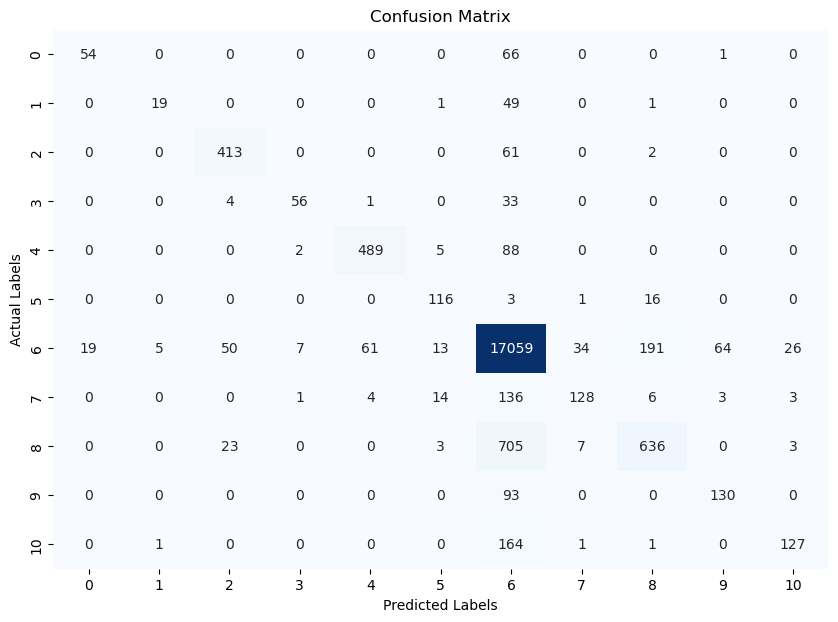

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
cm = confusion_matrix(new_actual_labels, new_predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.title('Confusion Matrix')
plt.show()


In [7]:
import dill
dill.dump_session('StudentCompleted_G.db')